In [1]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 30

RESULT_PATH = Path("../output/result.csv")
METRICS_MAP = {
    "exec_time": "実行時間 (秒)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "利用者満足度",
    "mean_max_envy": "平均最大羨望",
    "pct_item_util_better": "10% 改善割合",
    "pct_item_util_worse": "10% 改悪割合",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "関連度順",
    "expo_fair": "閲覧公平",
    "nsw": "NSW",
    "greedy_nsw": "NSW (貪欲) ",
    "ot_nsw": "NSW (提案) ",
    "pgd_nsw": "NSW (射影勾配法) ",
}
METHOD_TO_COLOR = {
    "関連度順": "#E24A33",
    "閲覧公平": "#FBC15E",
    "閲覧公平 (MOSEK) ": "#FBC15E",
    "閲覧公平 (SCS) ": "#FBC15E",
    "NSW (貪欲) ": "#777777",
    "NSW (既存) ": "#988ED5",
    "NSW (MOSEK) ": "#988ED5",
    "NSW (SCS) ": "#988ED5",
    "NSW (提案) ": "#348ABD",
    "NSW (射影勾配法) ": "#8EBA42",
}
METHOD_TO_LINESTYLE = {
    "関連度順": "-",
    "閲覧公平": "-",
    "閲覧公平 (MOSEK) ": "-",
    "閲覧公平 (SCS) ": "-",
    "NSW (貪欲) ": "-",
    "NSW (既存) ": "-",
    "NSW (MOSEK) ": "-",
    "NSW (SCS) ": "-",
    "NSW (提案) ": "-",
    "NSW (射影勾配法) ": "-",
}

In [2]:
def load_result(
    path: Path,
    exp_names: list[str],
    on: list[str] = ["seed"],
    ideal_method: str = "NSW (MOSEK) ",
    ignore_methods: list[str] = ["pg_ot"],
    ignore_solver: list[str] = ["SCS"],
    consider_solver: bool = True,
    dropna: bool = True,
) -> pd.DataFrame:
    result = pd.read_csv(path)

    # Filter by experiment name
    result = result.query(f"exp_name in {exp_names}")
    # # Filter by optimizer params method
    result = result.query(f"optimizer_name not in {ignore_methods}").reset_index(drop=True)
    # Filter by solver
    if consider_solver:
        result = result.query(f"optimizer_params_solver not in {ignore_solver}").reset_index(
            drop=True
        )

    # Initialize metrics
    result["exec_time_rate"] = np.nan

    # rename method
    result["method"] = result["optimizer_name"].map(METHOD_MAP)
    if consider_solver:
        result["optimizer_params_solver"] = result["optimizer_params_solver"].apply(
            lambda x: f" ({x}) " if x == x else ""
        )
        result["method"] += result["optimizer_params_solver"]

    #
    ideal = result.query("method == @ideal_method").reset_index(drop=True)
    ideal = ideal.drop_duplicates(subset=on)
    result = pd.merge(
        result[on + ["method"] + METRICS],
        ideal[on + METRICS],
        on=on,
        suffixes=("", "_nsw"),
        how="left",
    )

    # Calculate exec_time_rate
    result["exec_time_rate"] = result["exec_time"] / result["exec_time_nsw"]

    # drop na
    num_na: pd.DataFrame = result[METRICS].isna().sum(axis=0).to_frame()
    num_na.columns = ["number_of_nan"]
    display(num_na)
    if dropna:
        result = result.dropna(subset=METRICS)

    return result.reset_index(drop=True)

# ベースサイズの実験

In [14]:
def plot_metrics_bar(
    base_size_result: pd.DataFrame,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
) -> None:
    n_metrics = len(metrics)
    fig, axes = plt.subplots(ncols=n_metrics, figsize=(10 * n_metrics, 11), tight_layout=True)
    axes = np.ravel(axes)

    unique_method = base_size_result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]
    pallete = [METHOD_TO_COLOR[method] for method in order]

    for i, metric in enumerate(metrics):
        ax = sns.barplot(
            base_size_result,
            x="method",
            y=metric,
            ax=axes[i],
            legend=True,
            order=order,
            palette=pallete,
            hue="method",
            hue_order=order,
            errorbar=None,
        )
        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis="both", labelsize=35)
        ax.set_xticks([])

        if metric in ["pct_item_util_better", "pct_item_util_worse"]:
            ax.set_ylim(0, 105)

        # 棒グラフの上に値を追加
        for j, p in enumerate(ax.patches):
            height = p.get_height()
            if (height == 0) & (p.get_x() == 0):  # monky patch
                continue
            ax.text(
                p.get_x() + p.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=35,
            )

        handles, legend = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(
        handles,
        legend,
        fontsize=50,
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(order),
        loc="upper center",
    )

## データの読み込み

In [15]:
# 人工データ
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)
display(base_size_result.head(5))

# 実データ
base_size_real_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base_real"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,generator_params_n_doc,generator_K,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1000.0,500,10,4,NSW (提案),3.245440,0.000637,2.157313,0.000091,97.4,0.0,5093.972370,NaN,2.158096,0.000038,97.0,0.0
1,1000.0,500,10,3,NSW (提案),2.741403,0.000603,2.184140,0.000104,97.4,0.0,4549.397303,NaN,2.184864,0.000041,97.4,0.0
2,1000.0,500,10,2,NSW (提案),2.237131,0.000556,2.142570,0.000087,96.8,0.2,4020.717532,NaN,2.143812,0.000037,97.0,0.2
3,1000.0,500,10,1,NSW (提案),1.713122,0.000494,2.144855,0.000094,97.8,0.0,3467.584497,NaN,2.145651,0.000039,97.8,0.0
4,1000.0,500,10,0,NSW (提案),1.219407,0.000419,2.153757,0.000090,97.0,0.0,2912.228539,NaN,2.155045,0.000040,97.2,0.0


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


### 人工データ

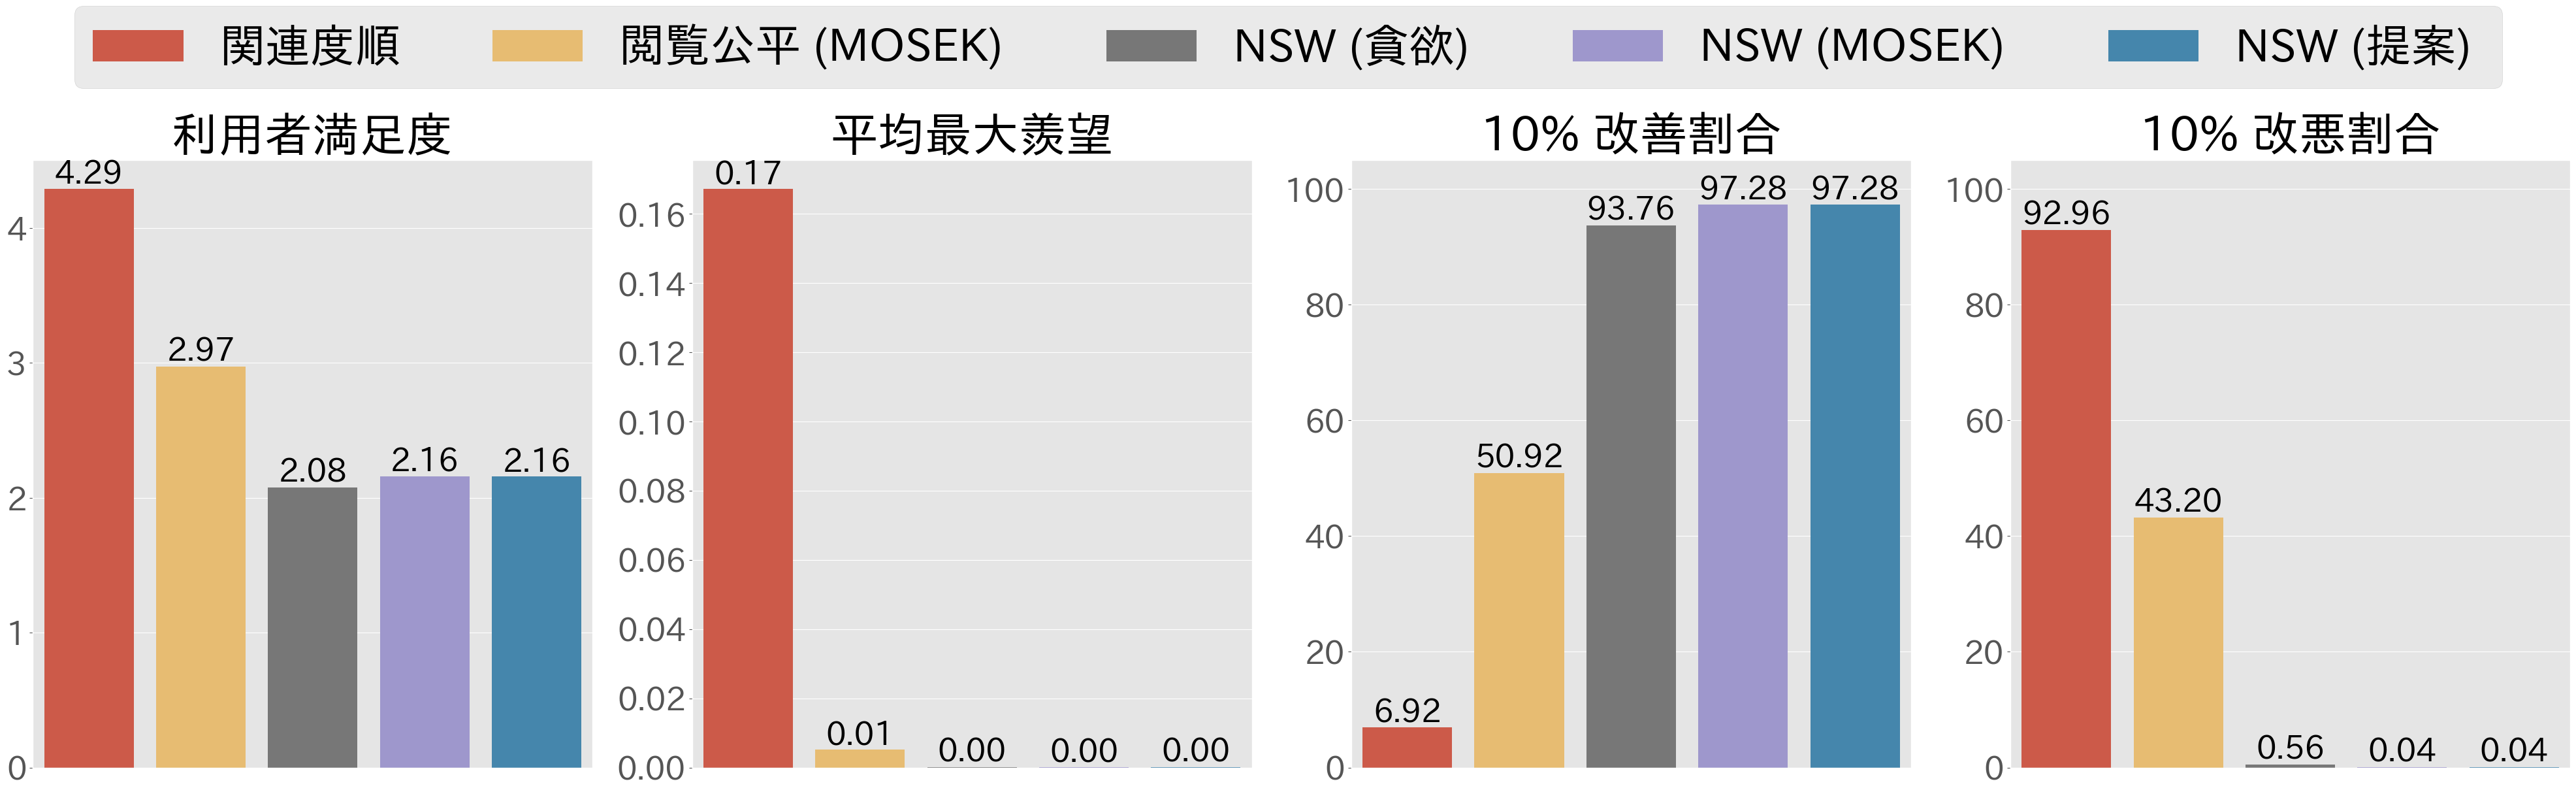

In [16]:
plot_metrics_bar(base_size_result)

### 実データ

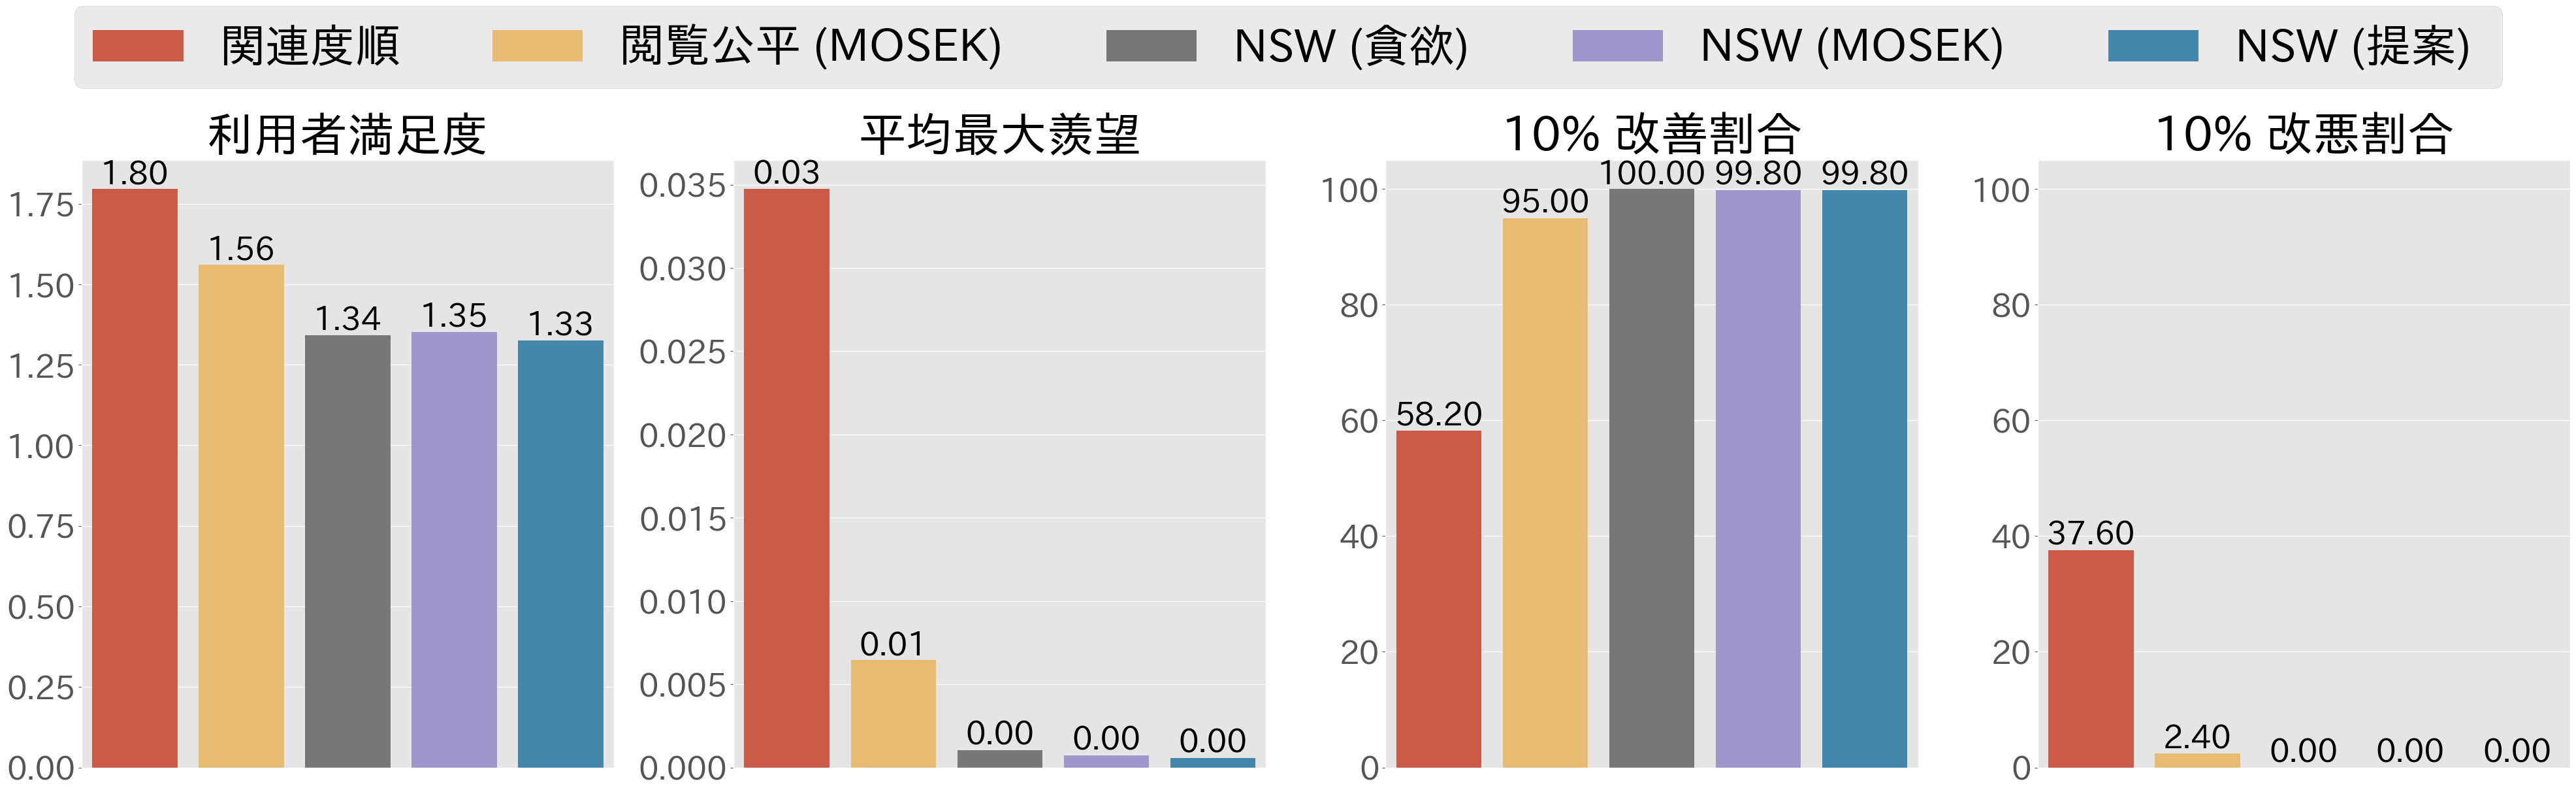

In [17]:
plot_metrics_bar(base_size_real_result)

# アイテム数、利用者数を変化させたときの実験

## 公平性、満足度

In [78]:
def plot_fairness_and_user_utils(result: pd.DataFrame, x: str, xlabel: str):
    fig, axes = plt.subplots(ncols=4, figsize=(45, 10), tight_layout=True)
    axes = np.ravel(axes)

    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(
        ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
    ):
        ax = axes[i]
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
                errorbar=None,
            )
        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.tick_params(axis="both", labelsize=35)

        handles, legend = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(
        handles,
        order,
        fontsize=50,
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(order),
        loc="upper center",
    )

In [79]:
# アイテム数を変化させた場合
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    consider_solver=True,
)
display(varying_item_size_result.head(5))

# 利用者数を変化させた場合
varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    consider_solver=True,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time,0
exec_time_rate,21
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW (射影勾配法),0.269689,0.000243,1.463792,2.987474e-10,0.0000,0.0000,1108.811406,NaN,2.146756,0.000014,97.7500,0.25
1,1600,1,NSW (射影勾配法),0.274246,0.000228,1.464292,2.146610e-10,0.0000,0.0000,1205.428054,NaN,2.158890,0.000014,97.6250,0.25
2,1600,0,NSW (射影勾配法),0.259585,0.000226,1.463197,1.778675e-10,0.0000,0.0000,1147.260273,NaN,2.148788,0.000015,97.5625,0.00
3,1600,4,NSW (提案),0.902199,0.000814,2.146827,6.602010e-05,97.9375,0.2500,1108.811406,NaN,2.146756,0.000014,97.7500,0.25
4,1600,1,NSW (提案),0.903618,0.000750,2.163427,6.549649e-05,97.1875,0.1875,1205.428054,NaN,2.158890,0.000014,97.6250,0.25


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,4,NSW (射影勾配法),0.272691,0.000894,1.464349,6.742142e-08,0.0,0.0,304.957495,NaN,2.158037,0.000071,96.4,0.0
1,1600.0,3,NSW (射影勾配法),0.280846,0.000934,1.466259,6.850070e-08,0.0,0.0,300.778249,NaN,2.165378,0.000075,96.8,0.0
2,1600.0,2,NSW (射影勾配法),0.272139,0.000899,1.462380,6.676076e-08,0.0,0.0,302.685821,NaN,2.154444,0.000073,97.2,0.4
3,1600.0,1,NSW (射影勾配法),0.267509,0.000884,1.464850,6.752176e-08,0.0,0.0,302.672586,NaN,2.167133,0.000070,96.8,0.0
4,1600.0,0,NSW (射影勾配法),0.269054,0.000913,1.463738,6.366891e-08,0.0,0.0,294.552099,NaN,2.139198,0.000074,97.2,0.0


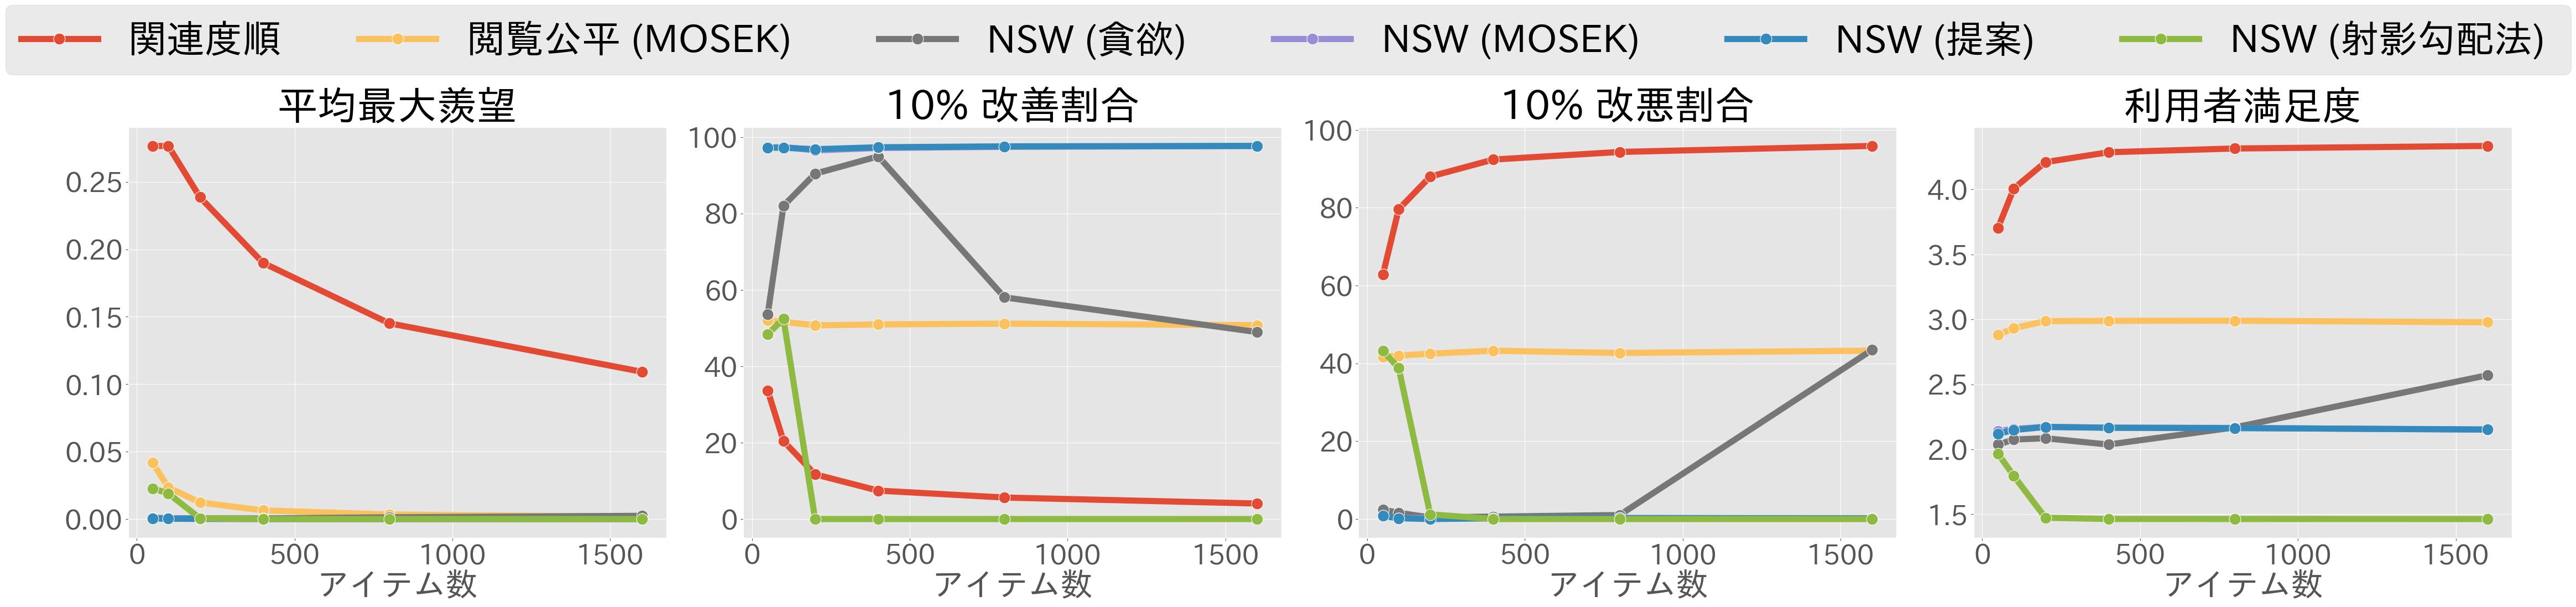

In [80]:
plot_fairness_and_user_utils(
    varying_item_size_result, x="generator_params_n_doc", xlabel="アイテム数"
)

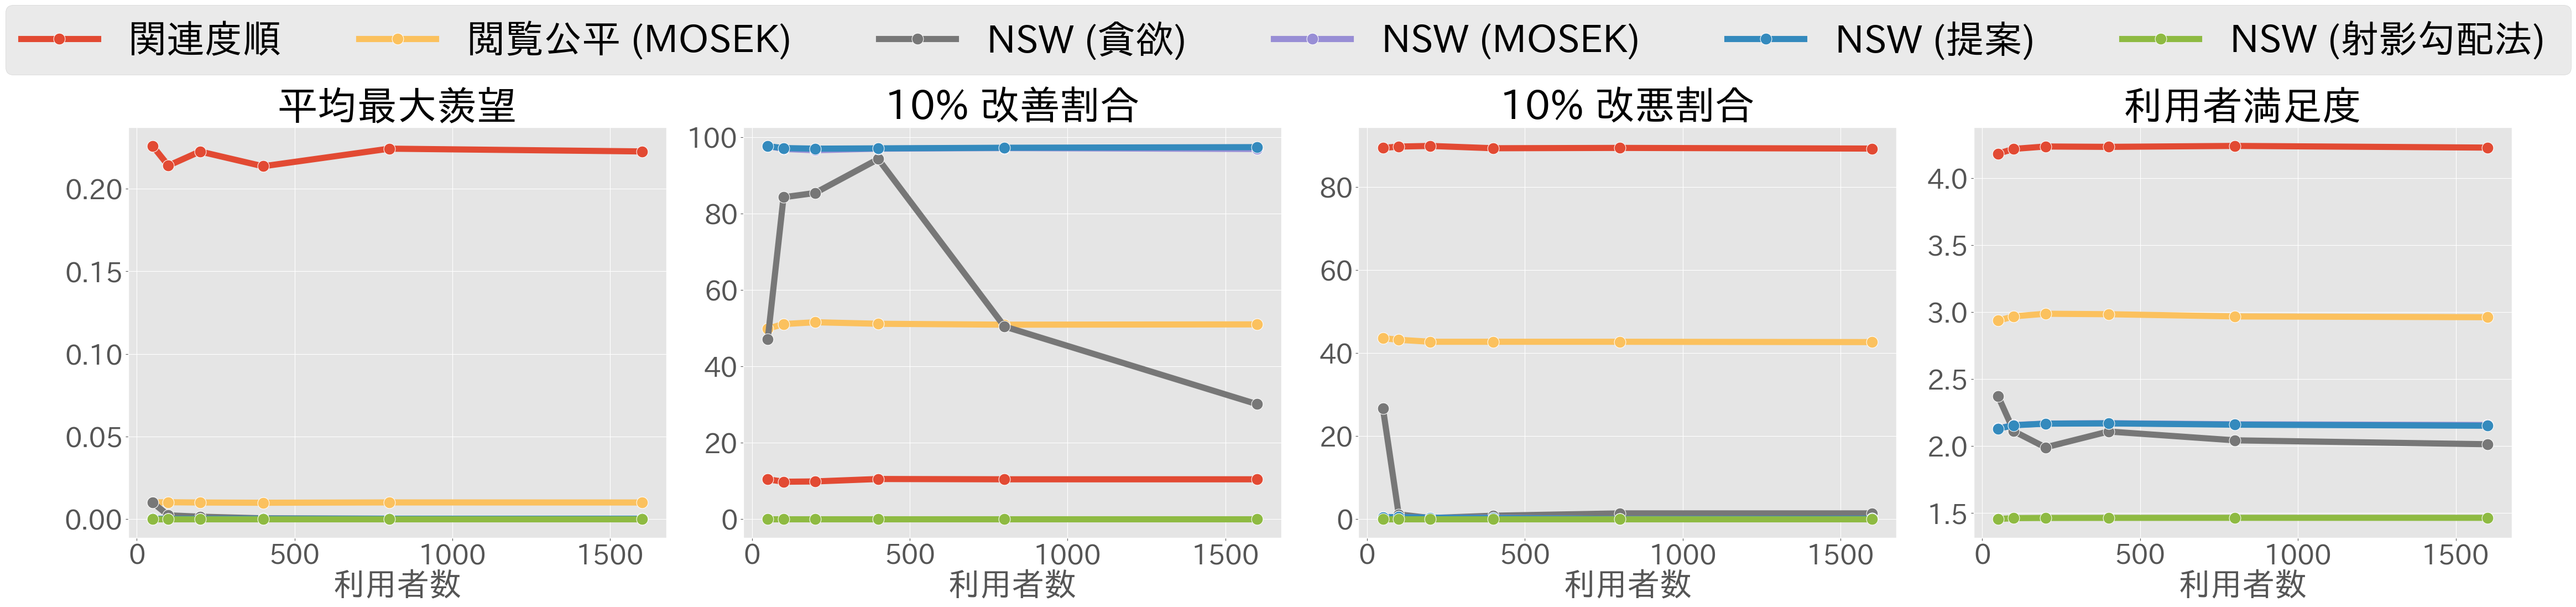

In [81]:
plot_fairness_and_user_utils(
    varying_user_size_result, x="generator_params_n_query", xlabel="利用者数"
)

## 実行時間

In [89]:
def plot_exec_time(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    figsize: tuple[int, int] = (14, 10),
):
    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(["exec_time", "exec_time_rate"]):
        ax: plt.Axes
        fig, ax = plt.subplots(figsize=figsize)
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
                errorbar=None,
            )
        ax.set_ylabel(METRICS_MAP[metric], fontsize=40)
        ax.set_xlabel(xlabel, fontsize=40)
        ax.set_yscale("log")
        ax.set_ylim(bottom=1e-3, top=3e3)
        ax.tick_params(axis="both", labelsize=30)

        if legend:
            handles, legend = ax.get_legend_handles_labels()
            ax.legend(
                handles,
                legend,
                loc="upper center",
                ncol=4,
                bbox_to_anchor=(0.5, 1.20),
            )
        else:
            ax.get_legend().remove()

    fig.tight_layout()


def plot_only_legend(ncol: int = 4, methods: list[str] = METHOD_TO_COLOR.keys()):
    fig, ax = plt.subplots(figsize=(14, 10))
    for method in methods:
        ax.plot([], [], label=method, color=METHOD_TO_COLOR[method], linewidth=8)
    ax.legend(
        loc="upper center",
        ncol=ncol,
        bbox_to_anchor=(0.5, 1.20),
        fontsize=40,
    )
    ax.axis("off")

In [90]:
ideal_method = "NSW (MOSEK) "
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_item_size_result.head(5))

varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time,0
exec_time_rate,15
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW (提案),0.902199,0.000814,2.146827,0.000066,97.9375,0.2500,1108.811406,NaN,2.146756,0.000014,97.7500,0.250
1,1600,1,NSW (提案),0.903618,0.000750,2.163427,0.000065,97.1875,0.1875,1205.428054,NaN,2.158890,0.000014,97.6250,0.250
2,1600,0,NSW (提案),0.904104,0.000788,2.148826,0.000065,97.8750,0.0625,1147.260273,NaN,2.148788,0.000015,97.5625,0.000
3,800,4,NSW (提案),0.430397,0.001742,2.158281,0.000056,97.6250,0.3750,247.035245,NaN,2.159054,0.000027,97.5000,0.375
4,800,3,NSW (提案),0.470818,0.002049,2.166543,0.000050,97.3750,0.0000,229.724557,NaN,2.167068,0.000029,97.5000,0.125


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,4,NSW (提案),0.179429,0.000588,2.152173,0.000198,97.2,0.0,304.957495,NaN,2.158037,0.000071,96.4,0.0
1,1600.0,3,NSW (提案),0.182421,0.000606,2.159340,0.000191,97.6,0.0,300.778249,NaN,2.165378,0.000075,96.8,0.0
2,1600.0,2,NSW (提案),0.180953,0.000598,2.149911,0.000211,97.2,0.4,302.685821,NaN,2.154444,0.000073,97.2,0.4
3,1600.0,1,NSW (提案),0.181002,0.000598,2.161106,0.000157,97.2,0.0,302.672586,NaN,2.167133,0.000070,96.8,0.0
4,1600.0,0,NSW (提案),0.184045,0.000625,2.135681,0.000164,97.6,0.0,294.552099,NaN,2.139198,0.000074,97.2,0.0


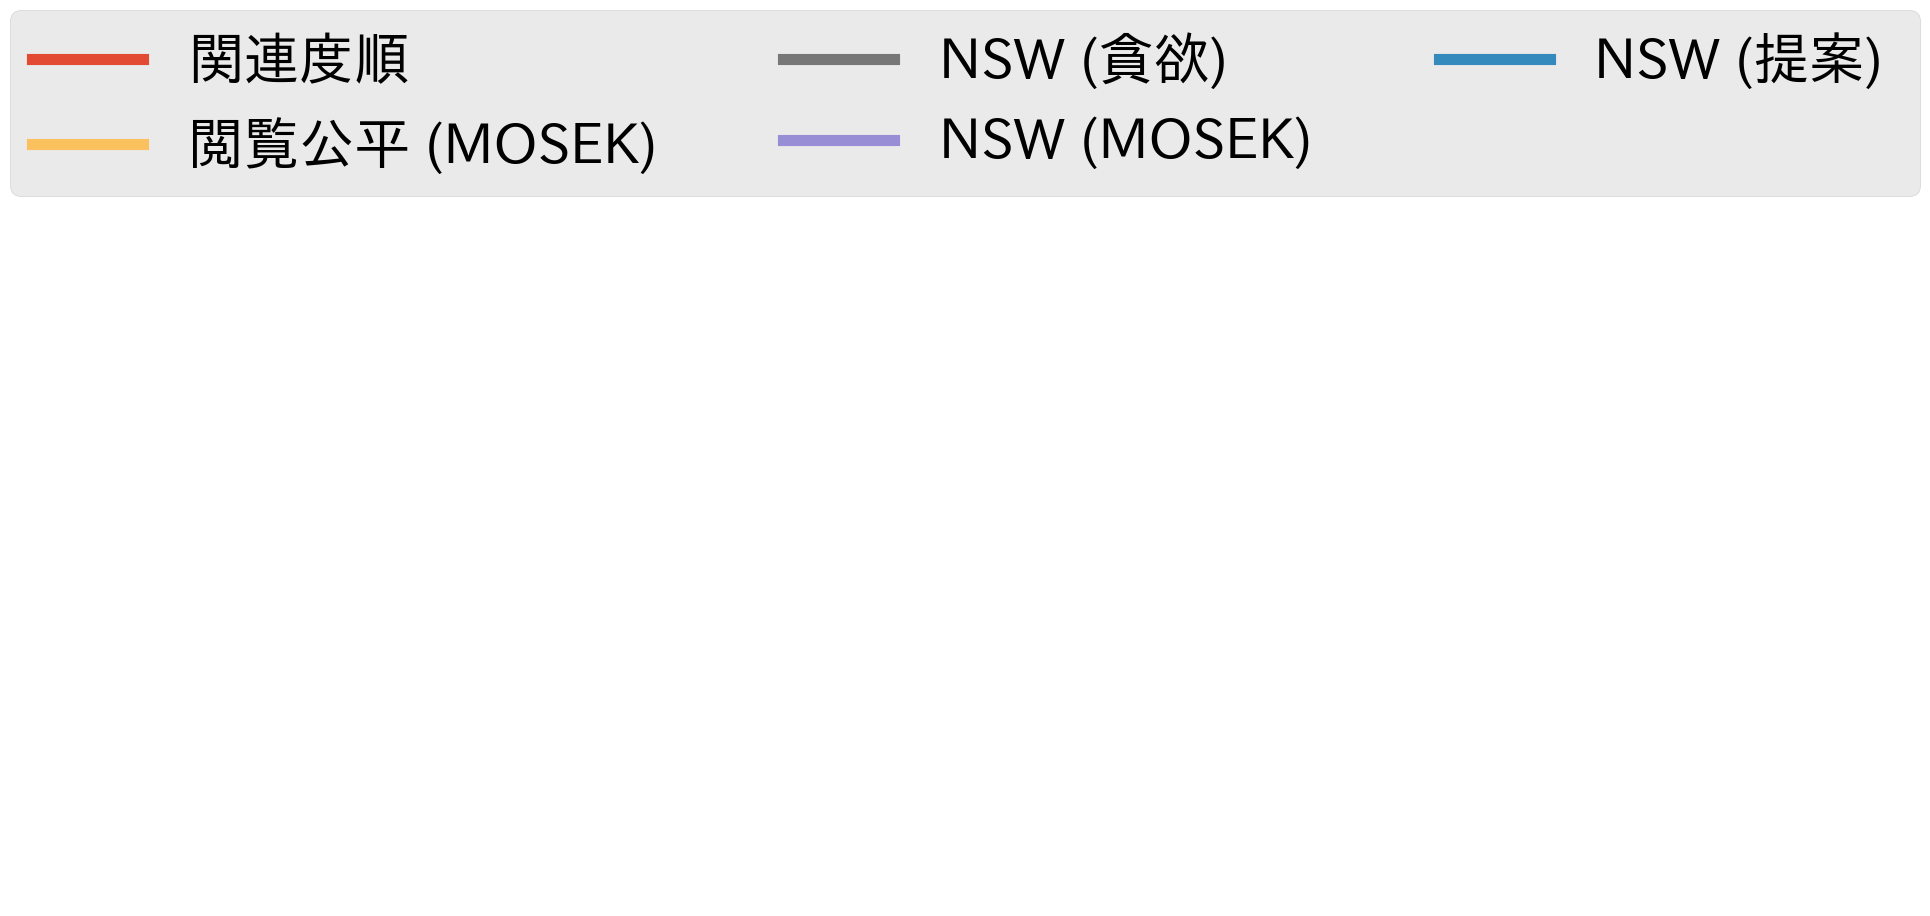

In [91]:
plot_only_legend(
    ncol=3,
    methods=["関連度順", "閲覧公平 (MOSEK) ", "NSW (貪欲) ", "NSW (MOSEK) ", "NSW (提案) "],
)

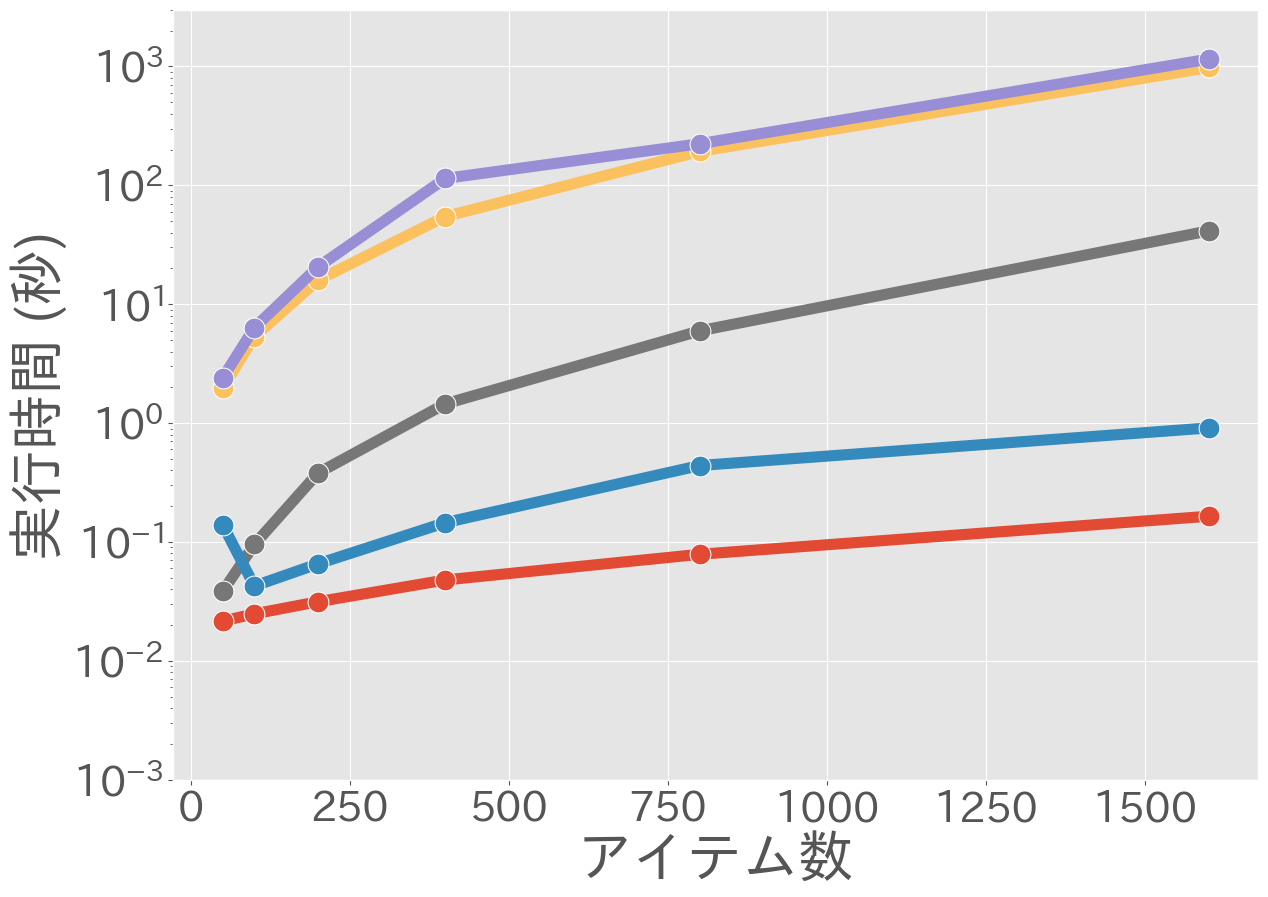

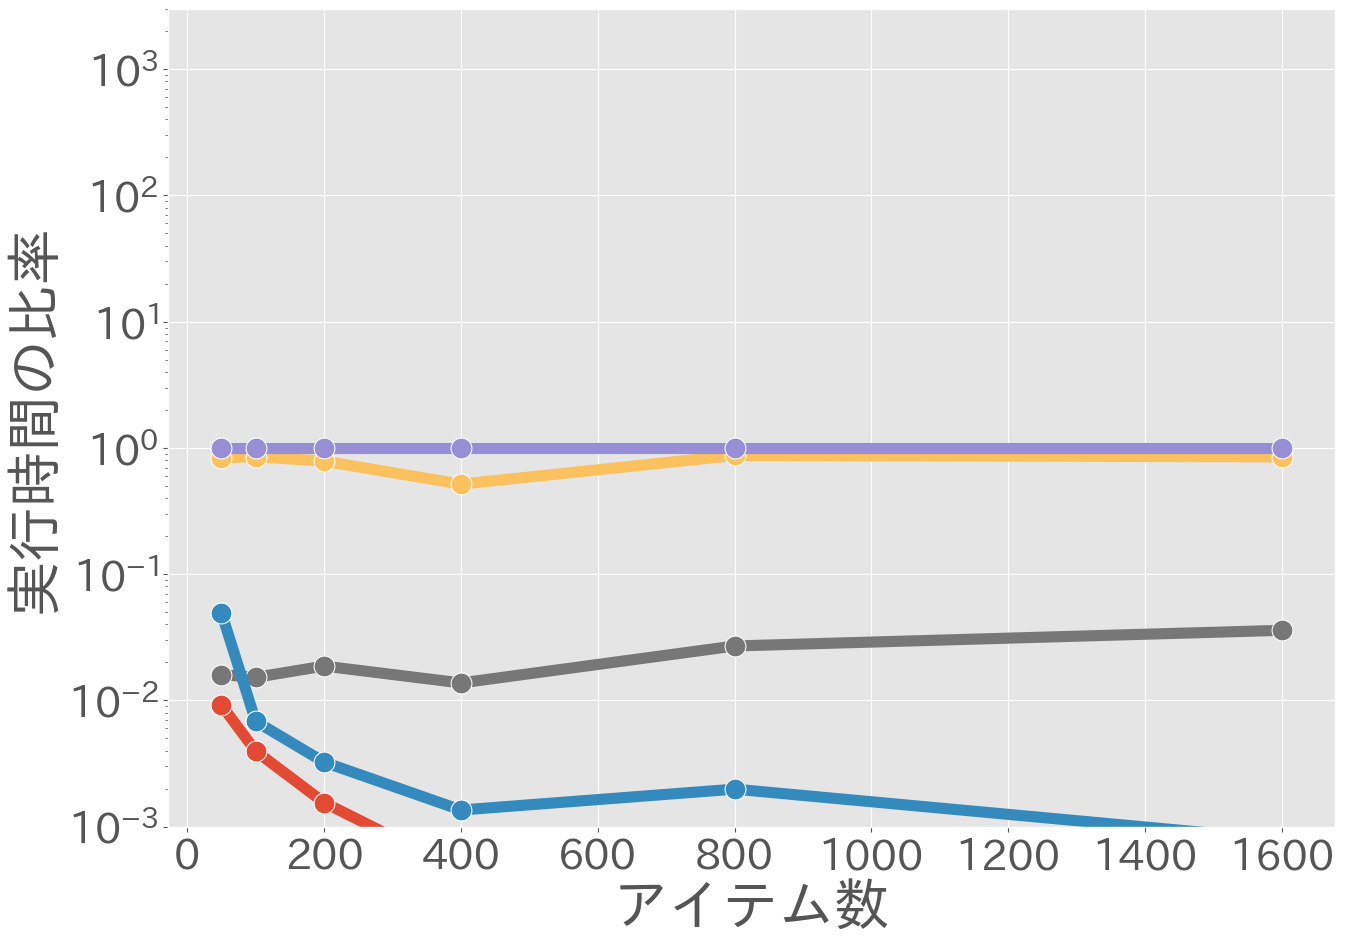

In [92]:
plot_exec_time(
    varying_item_size_result,
    x="generator_params_n_doc",
    xlabel="アイテム数",
    legend=False,
)

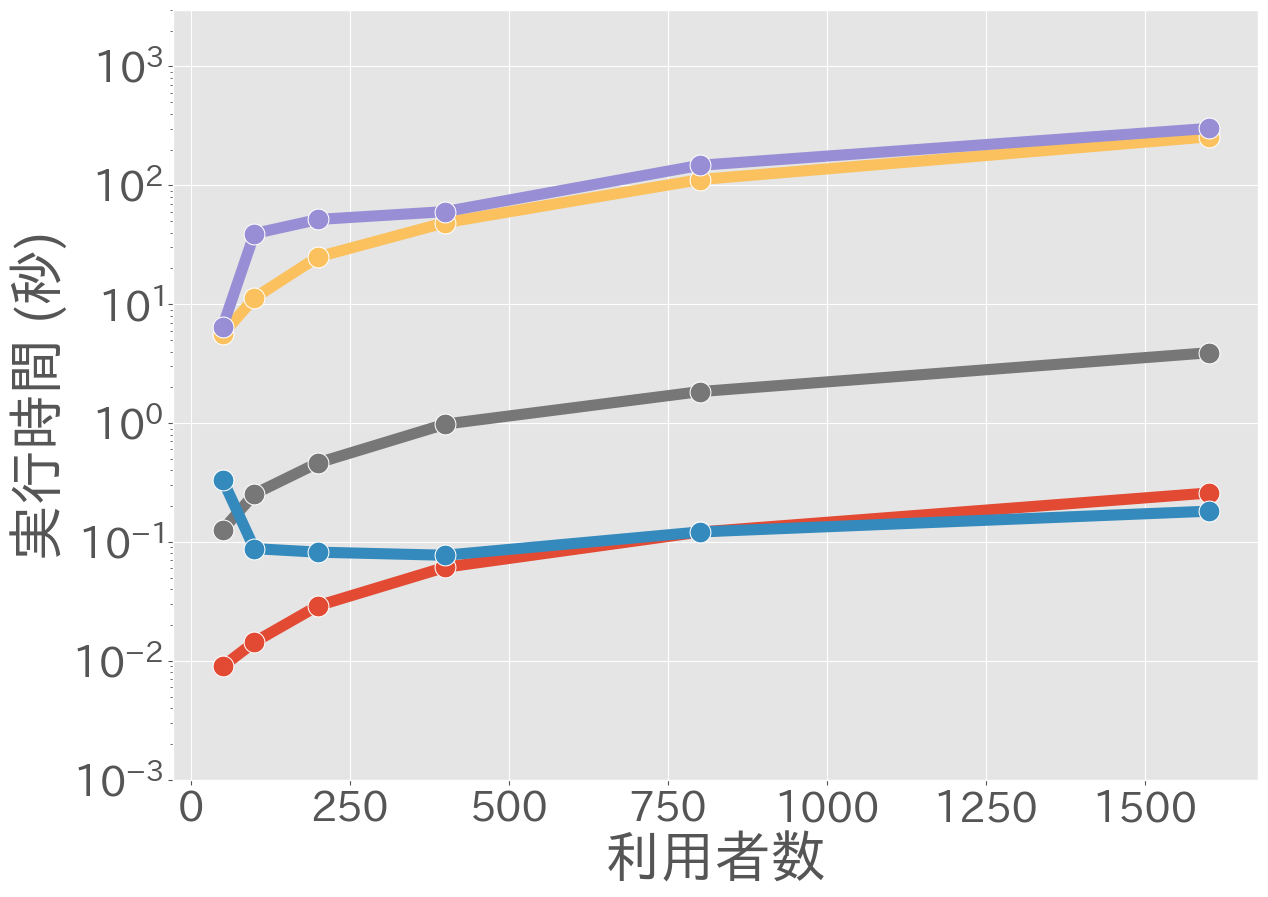

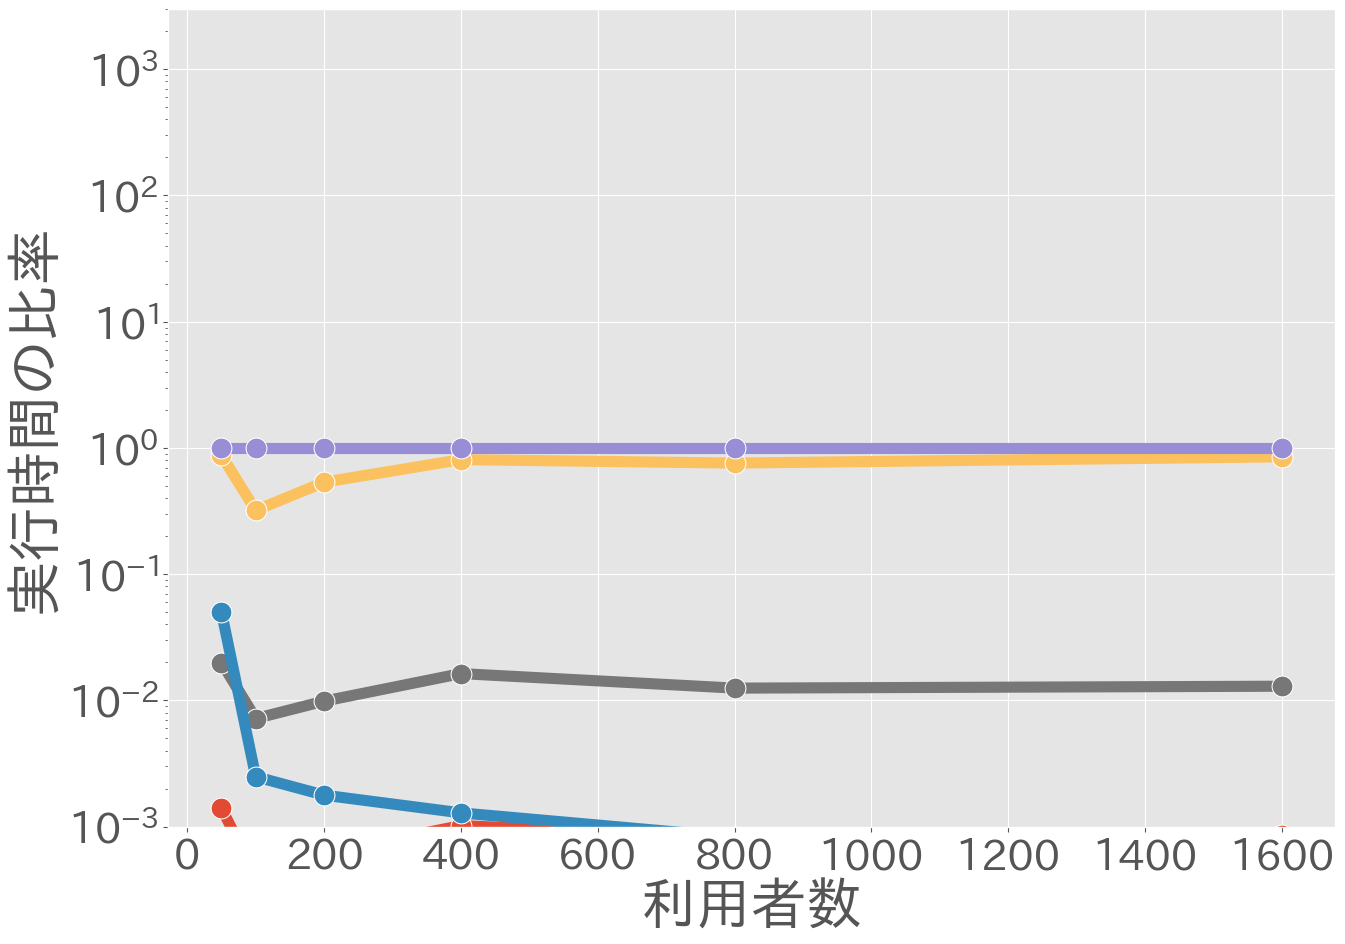

In [93]:
plot_exec_time(
    varying_user_size_result, x="generator_params_n_query", xlabel="利用者数", legend=False
)